In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [2]:
data_path = '/kaggle/input/denblood/masked_dataset.npz'
data = np.load(data_path)

images1 = data['processed_images']
labels1 = data['labels']

unique_labels, label_counts = np.unique(labels1, return_counts=True)
labels1 = tfk.utils.to_categorical(labels1, num_classes=len(unique_labels))

# Shuffle the data
shuffled_indices = np.random.permutation(len(images1))
images1 = images1[shuffled_indices]
labels1 = labels1[shuffled_indices]

images1 = images1 / 255.0


data_path = '/kaggle/input/denblood/unique_images.npz'
data = np.load(data_path)

images2 = data['images']
labels2 = data['labels']

unique_labels, label_counts = np.unique(labels2, return_counts=True)
labels2 = tfk.utils.to_categorical(labels2, num_classes=len(unique_labels))

# Shuffle the data
shuffled_indices = np.random.permutation(len(images2))
images2 = images2[shuffled_indices]
labels2 = labels2[shuffled_indices]

images2 = images2 / 255.0


In [17]:
print(images1.shape)

(11952, 96, 96, 3)


In [40]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images2,
    labels2,
    random_state=seed,
    test_size=0.1,
    stratify=np.argmax(labels2,axis=1)
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=0.1,
    stratify=np.argmax(y_train_val,axis=1)
)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (9680, 96, 96, 3), y_train shape: (9680, 8)
X_val shape: (1076, 96, 96, 3), y_val shape: (1076, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)


In [9]:
import tensorflow as tf
import keras_cv
from tensorflow.keras import layers as tfkl

# Define the augmentation pipeline
basic_aug = tf.keras.Sequential([
    tfkl.RandomRotation(0.4),
    tfkl.RandomContrast(0.8),
    keras_cv.layers.RandomSaturation(factor=(0.0, 0.7), seed=42),
    keras_cv.layers.RandomShear(
        x_factor=0.6,
        y_factor=0.6,
        interpolation="nearest",
        fill_mode="nearest",
        fill_value=0.0,
        bounding_box_format=None,
        seed=42
    ),
    keras_cv.layers.GridMask(
        ratio_factor=(0.3, 0.5),
        rotation_factor=0.1,
        fill_mode="constant",
        fill_value=0.0,
        seed=42
    )
], name="basic")

In [6]:
rand_aug = keras_cv.layers.RandAugment(
    value_range=(0, 1),
    augmentations_per_image=4,
    magnitude=0.6,
    magnitude_stddev=0.15,
    rate=0.9090909090909091,
    geometric=True,
    seed=42
)

In [7]:
X_train = rand_aug(X_train)

In [33]:
data_path = '/kaggle/input/denblood/masked_dataset.npz'
data = np.load(data_path)

images3 = data['processed_images'].copy()
labels3 = data['labels'].copy()

images3 = basic_aug(images3)

In [11]:
images1 = basic_aug(images1)

In [41]:
X_train = np.concatenate((X_train, images1), axis=0)
y_train = np.concatenate((y_train, labels1), axis=0)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (21632, 96, 96, 3), y_train shape: (21632, 8)
X_val shape: (1076, 96, 96, 3), y_val shape: (1076, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)


In [ ]:
unique_labels, label_counts = np.unique(labels3, return_counts=True)
labels3 = tfk.utils.to_categorical(labels3, num_classes=len(unique_labels))

In [ ]:


X_train = np.concatenate((X_train, images3), axis=0)
y_train = np.concatenate((y_train, labels3), axis=0)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

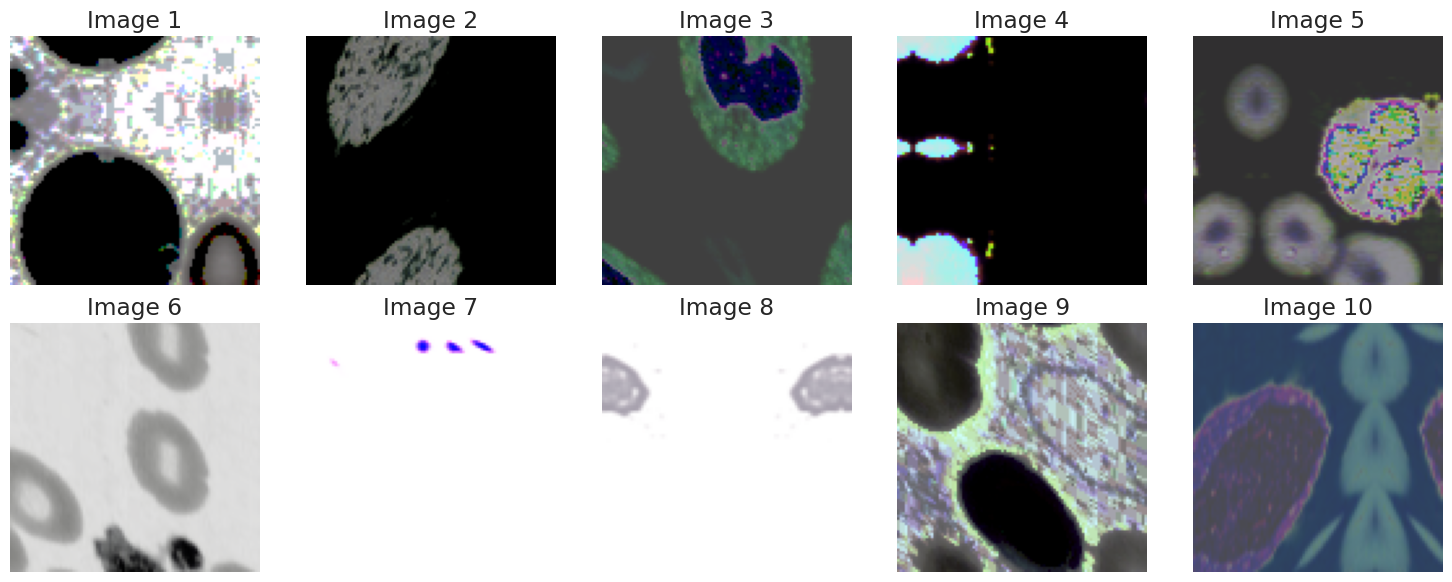

In [312]:
import matplotlib.pyplot as plt

# Assuming augmented_images is a NumPy array with shape (10, 96, 96, 3)
# Your augmented_images array should already be defined with shape (10, 96, 96, 3)

# Plot the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a grid of 2 rows and 5 columns

for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i])  # Show each image
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f'Image {i + 1}')  # Add title to each image

plt.tight_layout()  # Adjust spacing to avoid overlap
plt.show()  # Display the images

In [290]:
aug_sol = tf.keras.Sequential([
    keras_cv.layers.Solarization(
    value_range=(0.1, 0.7), addition_factor=0.8, threshold_factor=0.0, seed=42)
], name="solarization")



In [37]:
model = tfk.models.Sequential([
    
    tfk.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(96,96,3)),
    tfk.layers.BatchNormalization(),
    
    tfk.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    tfk.layers.MaxPool2D(pool_size=(3, 3)),
    
    tfk.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    tfk.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    tfk.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    
    tfk.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    tfk.layers.MaxPool2D(pool_size=(2, 2)),
    
    tfk.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    
    tfk.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    
    tfk.layers.MaxPool2D(pool_size=(2, 2)),
    
    tfk.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    tfk.layers.BatchNormalization(),
    
    tfk.layers.MaxPool2D(pool_size=(2, 2)),
    tfk.layers.Dropout(0.3),
    
    tfk.layers.GlobalAveragePooling2D(),
    
    tfk.layers.Dense(512, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Lion(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 30, 30, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 10, 10, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 10, 10, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 2, 2, 512)      │         2,04

 Total params: 10,104,968 (38.55 MB)

 Trainable params: 10,098,568 (38.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
       monitor='val_loss',  # Metric to monitor
       factor=0.2,          # Factor by which to reduce the learning rate
       patience=10,         # Number of epochs with no improvement after which to reduce LR
       min_lr=1e-7,         # Minimum learning rate
       verbose=1            # Print messages when LR is reduced
   )


# Train the model

tl_history = model.fit(

    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=80,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True),reduce_lr]

).history



# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file, including final accuracy in the filename

model_filename = '/kaggle/working/Inception_' + str(final_val_accuracy) + '.keras'

# Free memory by deleting the model instance

#del tl_model

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 57488
'y' sizes: 33584


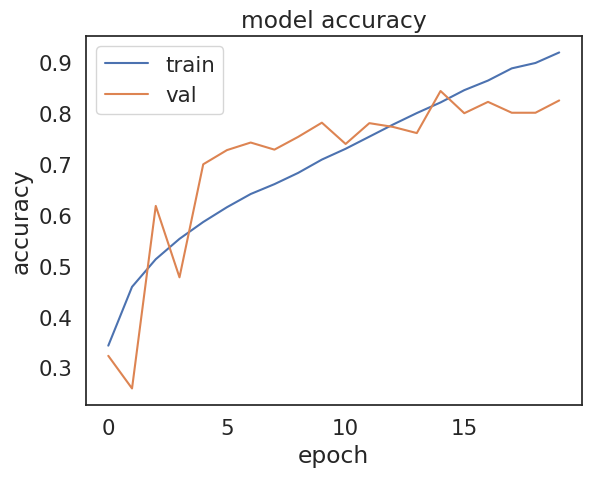

In [25]:
plt.plot(tl_history['accuracy'])
plt.plot(tl_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

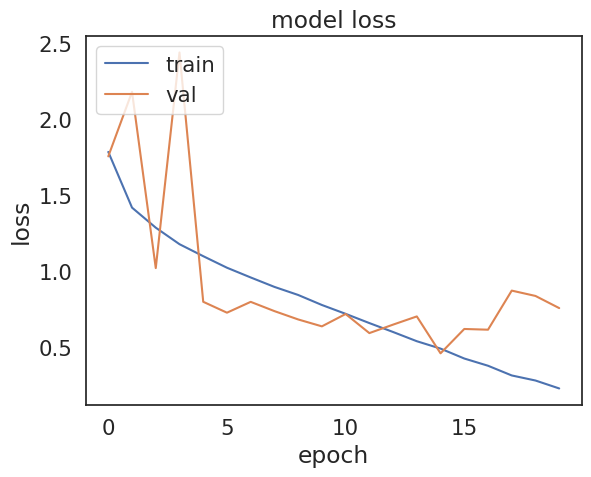

In [26]:
plt.plot(tl_history['loss'])
plt.plot(tl_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Accuracy score over the test set: 0.8311
Precision score over the test set: 0.8599
Recall score over the test set: 0.8311
F1 score over the test set: 0.8242


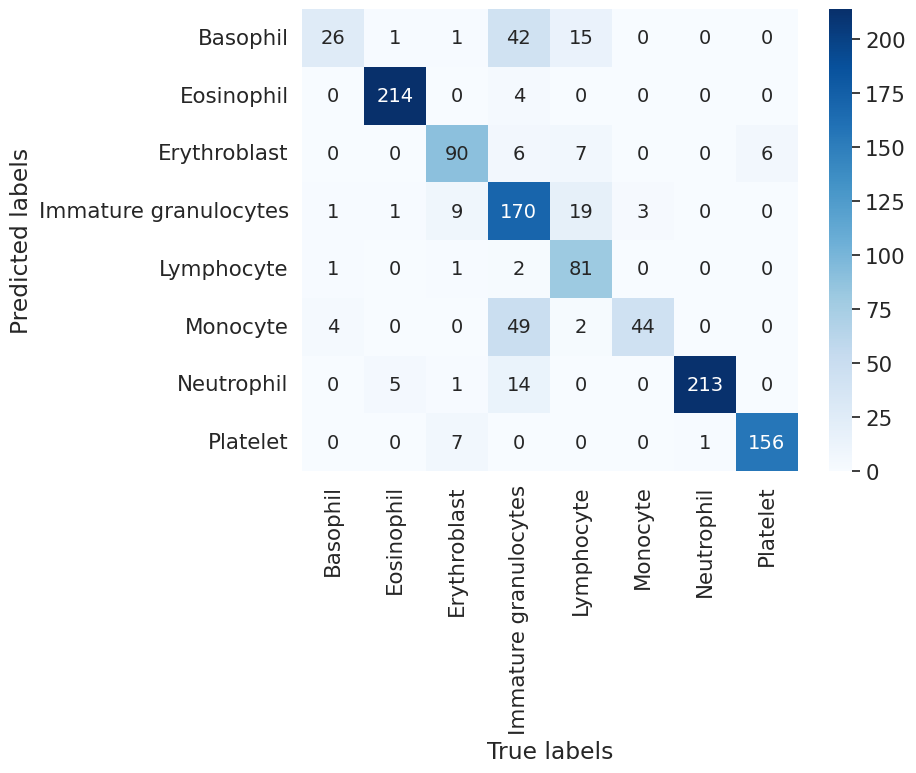

In [27]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil', 'Eosinophil', 'Erythroblast','Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], yticklabels=['Basophil', 'Eosinophil', 'Erythroblast','Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


In [ ]:
print(final_val_accuracy)

In [28]:
model_filename = 'Custom' + str(final_val_accuracy) + '.keras'

model.save(model_filename)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.utils as utils

# Carica il dataset
data_path = '/kaggle/input/denblood/unique_images.npz'
data = np.load(data_path)

images = data['images']
labels = data['labels']

images = images / 255

# Codifica le etichette in one-hot encoding
labels = utils.to_categorical(labels)

# Suddivisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Predici le probabilità delle classi e ottieni le classi predette
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Estrai le classi ground truth
test_gt = np.argmax(y_test, axis=-1)

# Calcola e visualizza l'accuratezza sul test set
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calcola e visualizza la precisione sul test set
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calcola e visualizza il recall sul test set
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calcola e visualizza il punteggio F1 sul test set
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calcola la matrice di confusione
cm = confusion_matrix(test_gt, test_predictions)

# Etichette delle classi
class_labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Crea etichette per la matrice di confusione
labels_cm = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualizza la matrice di confusione con le etichette delle classi
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels_cm, fmt='', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()